### 필요 라이브러리 불러오기

In [58]:
library(caret)
options(warn = -1, scipen = 100)
library(nnet)
library(e1071)
library(randomForest)
library(party)

### csv 읽어오기
- 앞선 과정에서 feature가 4개로 압축되었으므로 feature 4개와 target만 불러옴(3, 6, 7, 8, 9 column)

In [25]:
# read csv file
data <- read.csv("rproject/내가봤을때이거91퍼.csv")[,c(3,6,7,8,9)]

### data 이상치 제거하기
- 소요시간 60~400 값만 남김(60이하, 400초과 버림)

In [53]:
# 소요시간이 60 ~ 400인 값만 선택
data <- data[data$소요시간 >= 70 & data$소요시간 <= 400,]
head(data)

,출발시간,X1종.교통량,X2종.교통량,서울인구수,소요시간
1,0,3793419,229419,10388055,97
2,0,3793419,229419,10388055,89
5,0,3793419,229419,10388055,93
6,0,3793419,229419,10388055,74
7,0,3793419,229419,10388055,94
8,0,3793419,229419,10388055,90


### data_scaled 만들기
- target을 제외한, feature들을 모두 scale

In [27]:
data_scaled <- data
data_scaled[,1:4] <- scale(data_scaled[,1:4])
head(data_scaled)

,출발시간,X1종.교통량,X2종.교통량,서울인구수,소요시간
1,-1.682176,-0.829313,-0.8765689,1.121474,97
2,-1.682176,-0.829313,-0.8765689,1.121474,89
5,-1.682176,-0.829313,-0.8765689,1.121474,93
6,-1.682176,-0.829313,-0.8765689,1.121474,74
7,-1.682176,-0.829313,-0.8765689,1.121474,94
8,-1.682176,-0.829313,-0.8765689,1.121474,90


# linear

### 플롯 그리고 Cor 확인

,출발시간,X1종.교통량,X2종.교통량,서울인구수,소요시간
출발시간,1.000000000,0.27177410,0.001159174,-0.00292200,0.81601130
X1종.교통량,0.271774100,1.00000000,0.722902737,-0.36169530,0.07865364
X2종.교통량,0.001159174,0.72290274,1.000000000,0.09161766,-0.21311807
서울인구수,-0.002922000,-0.36169530,0.091617656,1.00000000,0.08001496
소요시간,0.816011304,0.07865364,-0.213118066,0.08001496,1.00000000


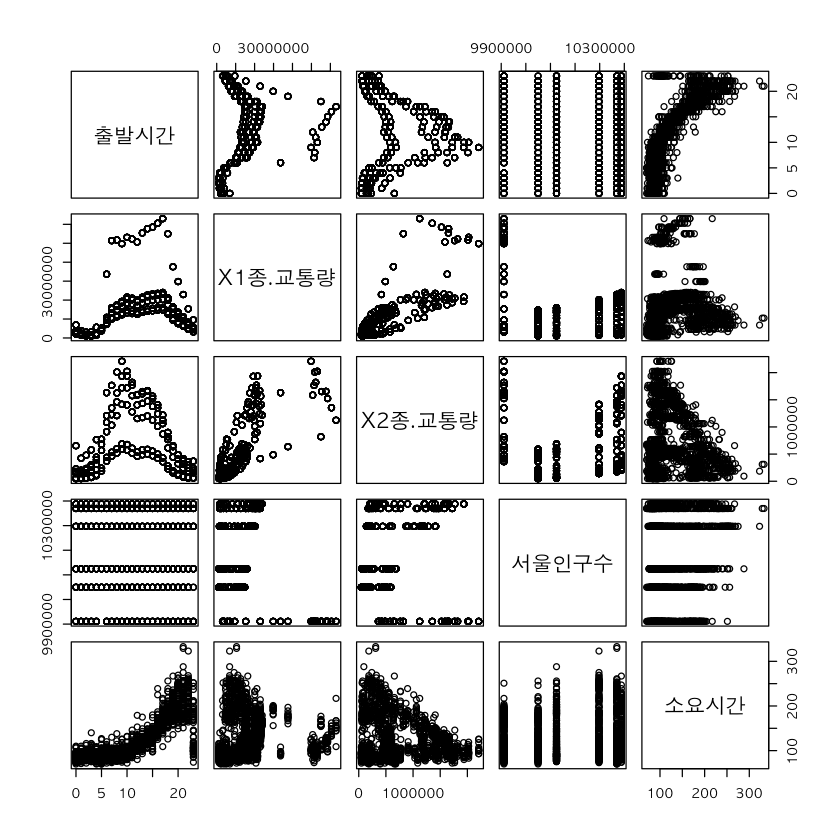

In [60]:
# draw plot for each column in data
par(bg = 'white', family='AppleGothic', font.size=20)
plot(data)
cor(data)

### 다중선형회귀분석 수행

In [61]:
model_lm <- lm(소요시간 ~ . , data = data)
summary(model_lm)



Call:
lm(formula = 소요시간 ~ ., data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-136.967  -12.389   -1.935   11.395  132.235 

Coefficients:
                    Estimate       Std. Error t value            Pr(>|t|)    
(Intercept) -530.30652397171   48.84534239832 -10.857 <0.0000000000000002 ***
출발시간       5.38092235926    0.10399213104  51.744 <0.0000000000000002 ***
X1종.교통량    0.00000087839    0.00000009311   9.434 <0.0000000000000002 ***
X2종.교통량   -0.00003565653    0.00000205463 -17.354 <0.0000000000000002 ***
서울인구수     0.00005978777    0.00000482403  12.394 <0.0000000000000002 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 25.39 on 1677 degrees of freedom
Multiple R-squared:  0.7362,	Adjusted R-squared:  0.7356 
F-statistic:  1170 on 4 and 1677 DF,  p-value: < 0.00000000000000022


# ML

### 출발시간 기준으로 데이터 샘플링해서 test와 tr 나누기
- data와 data_scaled의 row 순서가 동일하기 때문에 samp는 한 번만 해주면 된다

In [28]:
# data sampling
samp <- createDataPartition(data$출발시간, p=0.7, list=F)

In [29]:
data.tr <- data[samp,]
data.test <- data[-samp,]

data_scaled.tr <- data_scaled[samp,]
data_scaled.test <- data_scaled[-samp,]

### x(소요시간 제외한 모든 컬럼), y(소요시간 컬럼) 나누기

In [30]:
# 기본(not-scaled)에 대한 x, y 분류
x_tr <- subset(data.tr, select = -소요시간)
y_tr <- data.tr$소요시간
  
x_test <- subset(data.test, select = -소요시간)
y_test <- data.test$소요시간

# scaled에 대한 x, y 분류
x_scaled_tr <- subset(data_scaled.tr, select = -소요시간)
y_scaled_tr <- data_scaled.tr$소요시간

x_scaled_test <- subset(data_scaled.test, select = -소요시간)
y_scaled_test <- data_scaled.test$소요시간

### scaled data 이용해 인공신경망 방식으로 머신러닝 - 1회 테스트

In [38]:
# 인공신경망
  model_nnet <- nnet(소요시간 ~ ., data = data_scaled.tr, size = 10, trace = FALSE ,decay = 5e-04 , linout = TRUE)
  pred_nnet <- predict(model_nnet, x_scaled_test, type = "raw")
  예측력_nnet <- 1 - (sum((y_scaled_test - pred_nnet)^2) / sum((y_scaled_test - mean(y_scaled_test))^2))
  print(예측력_nnet)
# cbind(pred_nnet, as.character(y_scaled_test)) # 예측값 확인용

  # 인공신경망 train
  model_nnet_tr <- nnet(소요시간 ~ ., data = data_scaled.tr, size=10, trace=FALSE,decay = 5e-04, linout = TRUE)
  pred_nnet_tr <- predict(model_nnet_tr, x_scaled_tr, type="raw")
  예측력_nnet_tr <- 1 - (sum((y_scaled_tr - pred_nnet_tr)^2) / sum((y_scaled_tr - mean(y_tr))^2))
  print(예측력_nnet_tr)
# cbind(pred_nnet_tr, as.character(y_scaled_tr)) # 예측값 확인용

[1] 0.8612665
[1] 0.9081182


### data 이용해 나머지 방식으로 머신러닝 - 1회 테스트

In [49]:
model_rf <- randomForest(소요시간 ~ . , data = data.tr, ntree = 100)
model_svm <- svm(소요시간 ~ . , data = data.tr)
model_ctree <- ctree(소요시간 ~ . , data = data.tr)

# 테스트 데이터에 대한 예측
pred_rf <- predict(model_rf, x_test)
pred_svm <- predict(model_svm, x_test)
pred_ctree <- predict(model_ctree, x_test)

# 트레이닝 데이터에 대한 예측 - 테스트에 대한 예측보다 높아야 정상
pred_rf.tr <- predict(model_rf, x_tr)
pred_svm.tr <- predict(model_svm, x_tr)
pred_ctree.tr <- predict(model_ctree, x_tr)

예측력_rf <- 1 - (sum((y_test - pred_rf)^2) / sum((y_test - mean(y_test))^2))
예측력_svm <- 1 - (sum((y_test - pred_svm)^2) / sum((y_test - mean(y_test))^2))
예측력_ctree <- 1 - (sum((y_test - pred_ctree)^2) / sum((y_test - mean(y_test))^2))


예측력_rf.tr <- 1 - (sum((y_tr - pred_rf.tr)^2) / sum((y_tr - mean(y_tr))^2))
예측력_svm.tr <- 1 - (sum((y_tr - pred_svm.tr)^2) / sum((y_tr - mean(y_tr))^2))
예측력_ctree.tr <- 1 - (sum((y_tr - pred_ctree.tr)^2) / sum((y_tr - mean(y_tr))^2))

# sum_rf <- sum_rf + 예측력_rf
# sum_svm <- sum_svm + 예측력_svm
# sum_ctree <- sum_ctree + 예측력_ctree

# sum_rf.tr <- sum_rf.tr + 예측력_rf.tr
# sum_svm.tr <- sum_svm.tr + 예측력_svm.tr
# sum_ctree.tr <- sum_ctree.tr + 예측력_ctree.tr

cat('rf test / train / 차이 : ' , 예측력_rf , '/' , 예측력_rf.tr, '/' , 예측력_rf.tr - 예측력_rf)
cat('\nsvm test / train / 차이 : ' , 예측력_svm , '/' , 예측력_svm.tr, '/' , 예측력_svm.tr - 예측력_svm)
cat('\nctree test / train / 차이 : ' , 예측력_ctree , '/' , 예측력_ctree.tr, '/' , 예측력_ctree.tr - 예측력_ctree)

rf test / train / 차이 :  0.8903965 / 0.9187838 / 0.02838725
svm test / train / 차이 :  0.8538203 / 0.8365551 / -0.01726521
ctree test / train / 차이 :  0.8063786 / 0.8001426 / -0.006236058

### 5회 돌려서 평균 구하기

In [67]:
# for loop 5회 수행
sum_nnet <- 0
sum_rf <- 0
sum_svm <- 0
sum_ctree <- 0

sum_nnet_tr <- 0
sum_rf_tr <- 0
sum_svm_tr <- 0
sum_ctree_tr <- 0


for (i in 1:5) {
  model_nnet <- nnet(소요시간 ~ ., data = data_scaled.tr, size = 10, trace = FALSE ,decay = 5e-04 , linout = TRUE)
  model_rf <- randomForest(소요시간 ~ . , data = data.tr, ntree = 100)
  model_svm <- svm(소요시간 ~ . , data = data.tr)
  model_ctree <- ctree(소요시간 ~ . , data = data.tr)

  pred_nnet <- predict(model_nnet, x_scaled_test, type = "raw")
  pred_rf <- predict(model_rf, x_test)
  pred_svm <- predict(model_svm, x_test)
  pred_ctree <- predict(model_ctree, x_test)

  pred_nnet_tr <- predict(model_nnet, x_scaled_tr, type="raw")
  pred_rf.tr <- predict(model_rf, x_tr)
  pred_svm.tr <- predict(model_svm, x_tr)
  pred_ctree.tr <- predict(model_ctree, x_tr)

  예측력_nnet <- 1 - (sum((y_scaled_test - pred_nnet)^2) / sum((y_scaled_test - mean(y_scaled_test))^2))
  예측력_rf <- 1 - (sum((y_test - pred_rf)^2) / sum((y_test - mean(y_test))^2))
  예측력_svm <- 1 - (sum((y_test - pred_svm)^2) / sum((y_test - mean(y_test))^2))
  예측력_ctree <- 1 - (sum((y_test - pred_ctree)^2) / sum((y_test - mean(y_test))^2))

  예측력_nnet_tr <- 1 - (sum((y_scaled_tr - pred_nnet_tr)^2) / sum((y_scaled_tr - mean(y_tr))^2))
  예측력_rf.tr <- 1 - (sum((y_tr - pred_rf.tr)^2) / sum((y_tr - mean(y_tr))^2))
  예측력_svm.tr <- 1 - (sum((y_tr - pred_svm.tr)^2) / sum((y_tr - mean(y_tr))^2))
  예측력_ctree.tr <- 1 - (sum((y_tr - pred_ctree.tr)^2) / sum((y_tr - mean(y_tr))^2))

  sum_nnet <- sum_nnet + 예측력_nnet
  sum_rf <- sum_rf + 예측력_rf
  sum_svm <- sum_svm + 예측력_svm
  sum_ctree <- sum_ctree + 예측력_ctree

  sum_nnet_tr <- sum_nnet_tr + 예측력_nnet_tr
  sum_rf_tr <- sum_rf_tr + 예측력_rf.tr
  sum_svm_tr <- sum_svm_tr + 예측력_svm.tr
  sum_ctree_tr <- sum_ctree_tr + 예측력_ctree.tr
}


cat('nnet test / train / 차이 : ' , round(sum_nnet/5, 2) , '/' , round(sum_nnet_tr/5, 2), '/' , round((sum_nnet_tr - sum_nnet)/5, 2))
cat('\nrf test / train / 차이 : ' , round(sum_rf/5, 2) , '/' , round(sum_rf_tr/5, 2), '/' , round((sum_rf_tr - sum_rf)/5, 2))
cat('\nsvm test / train / 차이 : ' , round(sum_svm/5, 2) , '/' , round(sum_svm_tr/5, 2), '/' , round((sum_svm_tr - sum_svm)/5, 2))
cat('\nctree test / train / 차이 : ' , round(sum_ctree/5, 2) , '/' , round(sum_ctree_tr/5, 2), '/' , round((sum_ctree_tr - sum_ctree)/5, 2))


nnet test / train / 차이 :  0.84 / 0.85 / 0.01
rf test / train / 차이 :  0.89 / 0.92 / 0.03
svm test / train / 차이 :  0.85 / 0.84 / -0.02
ctree test / train / 차이 :  0.81 / 0.8 / -0.01

## 다중선형회귀, 4종류의 머신러닝 결과 가장 예측력이 높은 Random Forest Method를 선택

# 샘플링 하지 않은 전체 데이터를 학습해 모델로 저장
- 선택된 Random Forest 학습결과를 rds 파일로 저장한다

In [51]:
beep_model_rf <- randomForest(소요시간 ~ . , data = data, ntree = 100)

In [52]:
# save as rds
saveRDS(beep_model_rf, 'beep_model_rf.rds')